# Overfitted Model for test time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, PredefinedSplit

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
    AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder

from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
import shap


In [2]:
TRAIN_SET = '../data/Hotel-A-train.csv'
VAL_SET = '../data/Hotel-A-validation.csv'
TEST_SET = '../data/Hotel-A-test.csv'

In [3]:
df = pd.read_csv(TRAIN_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_val = pd.read_csv(VAL_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])
df_test = pd.read_csv(TEST_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout', 'Booking_date'])

Text(0, 0.5, 'frequency')

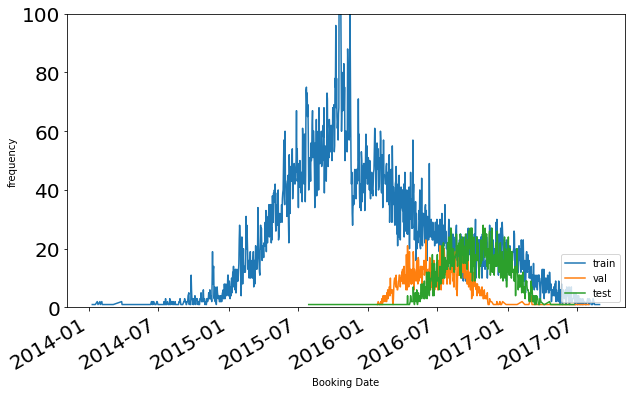

In [4]:
# fig, axs = plt.subplots(3, figsize=(10,10))
ylim = [0,100]
figsize=(10,6)
ax=df.Booking_date.rename('train').value_counts().sort_index().plot.line(ylim=ylim,figsize=figsize,fontsize=20)
df_val.Booking_date.rename('val').value_counts().sort_index().plot.line(ax=ax)
df_test.Booking_date.rename('test').value_counts().sort_index().plot.line(ax=ax)
plt.legend(loc='lower right')
plt.xlabel('Booking Date')
plt.ylabel('frequency')

In [5]:
split_date = '2016-05'
df_train_val = pd.concat([df,df_val]).sort_values(by='Booking_date')
df_new = df_train_val.loc[(df_train_val.Booking_date<=split_date)]
df_val_new = df_train_val.loc[(df_train_val.Booking_date>split_date)]
train_size = df_new.shape[0]
val_size = df_val_new.shape[0]
print('train:val = %.2f, train_size = %d, val_size = %d'%(train_size/val_size, train_size, val_size))

train:val = 2.33, train_size = 21153, val_size = 9095


In [6]:
df_overfit = df_train_val.loc[df_train_val.Booking_date.between('2016-04','2017-04')].copy()

In [7]:
df_overfit.columns

Index(['Gender', 'Age', 'Ethnicity', 'Educational_Level', 'Income',
       'Country_region', 'Hotel_Type', 'Expected_checkin', 'Expected_checkout',
       'Booking_date', 'Adults', 'Children', 'Babies', 'Meal_Type',
       'Visted_Previously', 'Previous_Cancellations', 'Deposit_type',
       'Booking_channel', 'Required_Car_Parking', 'Reservation_Status',
       'Use_Promotion', 'Discount_Rate', 'Room_Rate'],
      dtype='object')

In [8]:
cat_mask = df_overfit.dtypes=='object'
df_overfit.loc[:,cat_mask] = df_overfit.loc[:,cat_mask].astype('category')


In [9]:
cat_mask_test = df_test.dtypes == 'object'
df_test.loc[:, cat_mask_test] = df_test.loc[:, cat_mask_test].astype('category')

In [10]:
feature_cols = ['Gender', 'Age', 'Ethnicity', 'Educational_Level', 'Income',
       'Country_region', 'Hotel_Type', 'Adults', 'Children', 'Babies', 'Meal_Type',
       'Visted_Previously', 'Previous_Cancellations', 'Deposit_type',
       'Booking_channel', 'Required_Car_Parking', 
       'Use_Promotion', 'Discount_Rate', 'Room_Rate']

In [11]:
X_overfit = df_overfit[feature_cols]
y_overfit = df_overfit.Reservation_Status

In [12]:
X_test = df_test[feature_cols].copy()

In [13]:
clf = LGBMClassifier(n_estimators=1000, max_depth=1000, n_jobs=-1,random_state=42,class_weight='balanced')
clf.fit(X_overfit, y_overfit)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=1000, n_estimators=1000,
               random_state=42)

In [14]:
f1_score(y_overfit, clf.predict(X_overfit), average='macro')

1.0

In [15]:
X_test['Reservation_Status'] = clf.predict(X_test)

In [19]:
X_test['Reservation_Status'].map({'Check-In':1, 'Canceled':2, 'No-Show':3}).to_csv('../output/submission_file_16Mar_11_05pm.csv')

In [20]:
X_test['Reservation_Status'].value_counts()

Check-In    3582
Canceled     596
No-Show      140
Name: Reservation_Status, dtype: int64